In [46]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.math_utils as math_util
import math
import utils.latex_utils as tex
from scipy import stats
import utils.time_series_utils as ts_util
import json
import utils.measurement_utils as m_util

In [47]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.32-24


In [48]:
measurements_used = 1000
time_series_used = 10
# energy_per_time = 1000
generate_graphs = False
show_plots = True

get_timeseries = False
get_measurements = True

In [49]:
# exp_name = "compiler"
# exp_name = "measuring_instrument"
exp_name = "cores"

In [50]:
used_dut_name = [
    'workstationtwo',
    # 'workstationone',
]

used_dut_name.sort()

used_dut_env = 'prod'

windows = "win32nt"
linux = "unix"

used_os_names = [
    windows, 
    linux
]

used_test_case_names = [
    'fannkuch-redux.exe',
    'mandelbrot.exe',
    # 'idle-case.exe'
]

used_test_case_names.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"
rapl = "rapl"
clamp = "clamp"
plug = "plug"
scaphandre = "scaphandre"

windows_mi = [
    ipg, lhm, clamp, plug, scaphandre
]

linux_mi = [
    rapl, clamp, plug
]

used_mi_names = [
    clamp, ipg ##ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
]

ipg_sample_rate = 100
lhm_sample_rate = 100
rapl_sample_rate = 100
clamp_sample_rate = 100
plug_sample_rate = 200
scaphandre_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]

used_allocated_cores.sort()

In [51]:
if exp_name == "compiler":
    experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
    experiment_number = 1
    
    used_mi_names = [
        ipg
    ]
    
    used_compilers = [
        'clang', 'intel-one-api', 'min-gw', 'msvc'
    ]
    
    test_case_parameters = ["", "12", "16000"]

if exp_name == "measuring_instrument":
    experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
    experiment_number = 2
    
    used_mi_names = [
        ipg, scaphandre, lhm, plug, rapl, clamp, rapl
        # ipg, clamp, plug, lhm, rapl #, lhm, scaphandre, # plug, rapl
        # lhm#, plug
        # lhm #clamp
        # rapl, plug
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    test_case_parameters = ["", "12", "64000"]

if exp_name == 'cores':
    experiment_name = "same-one-api-compiler-different-cores"
    experiment_number = 3
    
    used_mi_names = [
        ipg
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    used_test_case_names = [
        'nbody.exe',
        'spectral-norm.exe',
        # 'idle-case.exe'
    ]
    
    used_thread = [
        'single-threaded'
    ]
    
    used_allocated_cores = [
        ['0'], 
        ['1'], 
        ['2'],
        ['3'],
        ['4'],
        ['5'],
        ['6'],
        ['7'],
        ['8'],
        ['9'],
    ]
    
    used_os_names = [
        windows
    ]   
    
    test_case_parameters = ["", "180000000", "18000"]


used_mi_names.sort()
used_compilers.sort()

In [52]:
used_test_case_names

['nbody.exe', 'spectral-norm.exe']

### DUTs

In [53]:
used_dut_name_str = "','".join(used_dut_name)
used_os_name_str = "','".join(used_os_names)

In [54]:
dut = rep.get_devices_under_test(db)
dut.shape

(7, 4)

In [55]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}') and Os in ('{used_os_name_str}')")

used_dut.shape

(1, 4)

### Test Cases

In [56]:
tc = rep.get_test_cases(db)

tc.shape

(30, 8)

In [57]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)
used_test_case_parameters = "','".join(test_case_parameters)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}') and Parameter in ('{used_test_case_parameters}')")

In [58]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

### Measuring Instruments

In [59]:
mi = rep.get_measuring_instruments(db)

mi.shape

(15, 3)

In [60]:
used_mi_query_list =  query.get_mi_query(
    used_mi_names,
    ipg,
    lhm,
    rapl,
    plug,
    clamp,
    scaphandre,
    ipg_sample_rate,
    lhm_sample_rate,
    rapl_sample_rate,
    plug_sample_rate,
    clamp_sample_rate,
    scaphandre_sample_rate,
)

used_mi = mi.query(" or ".join(used_mi_query_list))

### Configurations

In [61]:
used_allocated_cores_str = ",".join([str(x) for x in used_allocated_cores])
used_allocated_cores_str = used_allocated_cores_str.replace("'", '')
used_allocated_cores_str = used_allocated_cores_str.replace("[", "'[")
used_allocated_cores_str = used_allocated_cores_str.replace("]", "]'")

In [62]:
config = rep.get_configurations(db)

config.shape

(15, 5)

In [63]:
config.shape

(15, 5)

In [64]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            # f"{ALLOCATED_CORES} in ('[1]')")
                            f"{ALLOCATED_CORES} in ({used_allocated_cores_str})")
                            # f"CAST({ALLOCATED_CORES} as CHAR) = [{used_allocated_cores_str}]")
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
5,6,0,200,1,[0]
6,7,0,200,1,[1]
7,8,0,200,1,[2]
8,9,0,200,1,[3]
9,10,0,200,1,[4]
10,11,0,200,1,[5]
11,12,0,200,1,[6]
12,13,0,200,1,[7]
13,14,0,200,1,[8]
14,15,0,200,1,[9]


### Experiment Names

In [65]:
exp = rep.get_distinct_experiments(db)

exp.shape

(7, 2)

## Used Things

In [66]:
used_dut

,Id,Name,Os,Env
4,5,workstationtwo,win32nt,prod


In [67]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
27,31,nbody.exe,intel-one-api,c++,,microbenchmarks,180000000,single-threaded
28,32,spectral-norm.exe,intel-one-api,c++,,microbenchmarks,18000,single-threaded


In [68]:
used_mi

,Id,Name,SampleRate
0,1,ipg,100


In [69]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
29,33,idle-case.exe,intel-one-api,c++,,microbenchmarks,,single-threaded


In [70]:
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
5,6,0,200,1,[0]
6,7,0,200,1,[1]
7,8,0,200,1,[2]
8,9,0,200,1,[3]
9,10,0,200,1,[4]
10,11,0,200,1,[5]
11,12,0,200,1,[6]
12,13,0,200,1,[7]
13,14,0,200,1,[8]
14,15,0,200,1,[9]


In [71]:
time_series = {}

if get_timeseries:
    time_series = ts_util.get_time_series(
        used_dut,
        used_mi,
        used_configs,
        used_tc,
        experiment_name,
        experiment_number,
        linux,
        windows,
        windows_mi,
        linux_mi,
        time_series_used,
        db,
        scaphandre
    )

In [72]:
# [x for x in time_series[0]["fannkuch-redux.exe.rapl.workstationone.all.intel-one-api.unix"].iterrows()]

In [73]:
for key in time_series.keys():
    print(key)
    for table in time_series[key]:
        if "clamp" in key or "plug" in key or "scaphandre" in key or 'lhm' in key:
            table.plot(x="ElapsedTime", y="CpuEnergyInJoules")
        if "ipg" in key:
            table.plot(x="ElapsedTime", y="ProcessorPowerInWatt")
        if "rapl" in key:
            table['rapl_column'] = df_util.get_rapl_column(table, "total_core")
            table.plot(x="ElapsedTime", y="rapl_column")
        plot.show()

In [74]:
used_configs.shape, used_dut.shape, used_mi.shape, used_tc.shape, used_idle_case.shape


((10, 5), (1, 4), (1, 3), (2, 8), (1, 8))

In [75]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
27,31,nbody.exe,intel-one-api,c++,,microbenchmarks,180000000,single-threaded
28,32,spectral-norm.exe,intel-one-api,c++,,microbenchmarks,18000,single-threaded


In [76]:
cpu_energy_results = {}
dram_energy_results = {}
gpu_energy_results = {}
duration_results = {}

idle_cpu_consumption_results = {}

cpu_dynamic_energy_watt_consumption = {}

cpu_dynamic_energy_consumption = {}
gpu_dynamic_energy_consumption = {}
dram_dynamic_energy_consumption = {}

temperature_begin = {}
temperature_end = {}

if get_measurements:
    m_util.get_measurements(
        windows,
        windows_mi,
        linux,
        linux_mi,
        used_configs,
        used_dut,
        used_mi,
        used_tc,
        used_idle_case,
        db,
        experiment_name,
        experiment_number,
        # energy_per_time,
        scaphandre,
        cpu_energy_results,
        dram_energy_results,
        gpu_energy_results,
        duration_results,
        temperature_begin,
        temperature_end,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        used_test_case_name,
        cpu_dynamic_energy_watt_consumption
    )

Y - nbody.exe.win32nt.workstationtwo.[0].intel-one-api.ipg.100.31
Y - spectral-norm.exe.win32nt.workstationtwo.[0].intel-one-api.ipg.100.32
Y - nbody.exe.win32nt.workstationtwo.[1].intel-one-api.ipg.100.31
Y - spectral-norm.exe.win32nt.workstationtwo.[1].intel-one-api.ipg.100.32
Y - nbody.exe.win32nt.workstationtwo.[2].intel-one-api.ipg.100.31
Y - spectral-norm.exe.win32nt.workstationtwo.[2].intel-one-api.ipg.100.32
Y - nbody.exe.win32nt.workstationtwo.[3].intel-one-api.ipg.100.31
Y - spectral-norm.exe.win32nt.workstationtwo.[3].intel-one-api.ipg.100.32
Y - nbody.exe.win32nt.workstationtwo.[4].intel-one-api.ipg.100.31
Y - spectral-norm.exe.win32nt.workstationtwo.[4].intel-one-api.ipg.100.32
Y - nbody.exe.win32nt.workstationtwo.[5].intel-one-api.ipg.100.31
Y - spectral-norm.exe.win32nt.workstationtwo.[5].intel-one-api.ipg.100.32
Y - nbody.exe.win32nt.workstationtwo.[6].intel-one-api.ipg.100.31
Y - spectral-norm.exe.win32nt.workstationtwo.[6].intel-one-api.ipg.100.32
Y - nbody.exe.win32n

In [77]:
if get_measurements:
    df_util.trim_dataframes(
        measurements_used,
        dram_energy_results,
        cpu_energy_results,
        gpu_energy_results,
        duration_results,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        temperature_end,
        temperature_begin,
        cpu_dynamic_energy_watt_consumption
    )

In [78]:
def convert_to_series(df):
    for key in df.keys():
        df[key] = pd.Series(df[key])
    return df

In [79]:
if get_measurements:
    ## Energy consumption for the entire test case
    dram_energy_results = convert_to_series(dram_energy_results)
    dram_df = pd.DataFrame(dram_energy_results)
    dram_df =dram_df.reindex(columns=sorted(dram_df.columns))

    cpu_energy_results = convert_to_series(cpu_energy_results)
    cpu_df = pd.DataFrame(cpu_energy_results)
    cpu_df = cpu_df.reindex(columns=sorted(cpu_df.columns))

    gpu_energy_results = convert_to_series(gpu_energy_results)
    gpu_df = pd.DataFrame(gpu_energy_results)
    gpu_df = gpu_df.reindex(columns=sorted(gpu_df.columns))

    duration_results = convert_to_series(duration_results)
    duration_df = pd.DataFrame(duration_results)
    duration_df = duration_df.reindex(columns=sorted(duration_df.columns))

    ## Dynamic energy data frames
    dram_dynamic_energy_consumption = convert_to_series(dram_dynamic_energy_consumption)
    dram_dynamic_df = pd.DataFrame(dram_dynamic_energy_consumption)
    dram_dynamic_df = dram_dynamic_df.reindex(columns=sorted(duration_df.columns))

    cpu_dynamic_energy_consumption = convert_to_series(cpu_dynamic_energy_consumption)
    cpu_dynamic_df = pd.DataFrame(cpu_dynamic_energy_consumption)
    cpu_dynamic_df = cpu_dynamic_df.reindex(columns=sorted(cpu_dynamic_df.columns))
    
    cpu_dynamic_energy_watt_consumption = convert_to_series(cpu_dynamic_energy_watt_consumption)
    cpu_dynamic_watt_df = pd.DataFrame(cpu_dynamic_energy_watt_consumption)
    cpu_dynamic_watt_df = cpu_dynamic_watt_df.reindex(columns=sorted(cpu_dynamic_watt_df.columns))

    gpu_dynamic_energy_consumption = convert_to_series(gpu_dynamic_energy_consumption)
    gpu_dynamic_df = pd.DataFrame(gpu_dynamic_energy_consumption)
    gpu_dynamic_df = gpu_dynamic_df.reindex(columns=sorted(gpu_dynamic_df.columns))

    idle_cpu_consumption_results = convert_to_series(idle_cpu_consumption_results)
    idle_cpu_df = pd.DataFrame(idle_cpu_consumption_results)
    idle_cpu_df = idle_cpu_df.reindex(columns=sorted(idle_cpu_df.columns))

    temperature_begin = convert_to_series(temperature_begin)
    temperature_begin_df = pd.DataFrame(temperature_begin)
    temperature_begin_df = temperature_begin_df.reindex(columns=sorted(temperature_begin_df.columns))

    temperature_end = convert_to_series(temperature_end)
    temperature_end_df = pd.DataFrame(temperature_end)
    temperature_end_df = temperature_end_df.reindex(columns=sorted(temperature_end_df.columns))




In [80]:
if get_measurements:
    for column in duration_df.columns:
        duration_df[column] = duration_df[column] / 1000

In [81]:
max(list(cpu_df.max()))

362.12933349609375

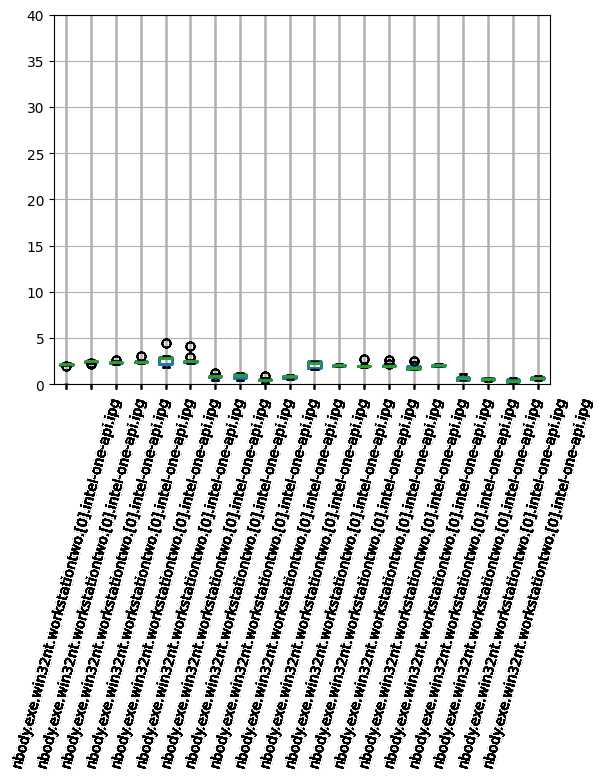

Combined CPU Energy Consumption in Joules


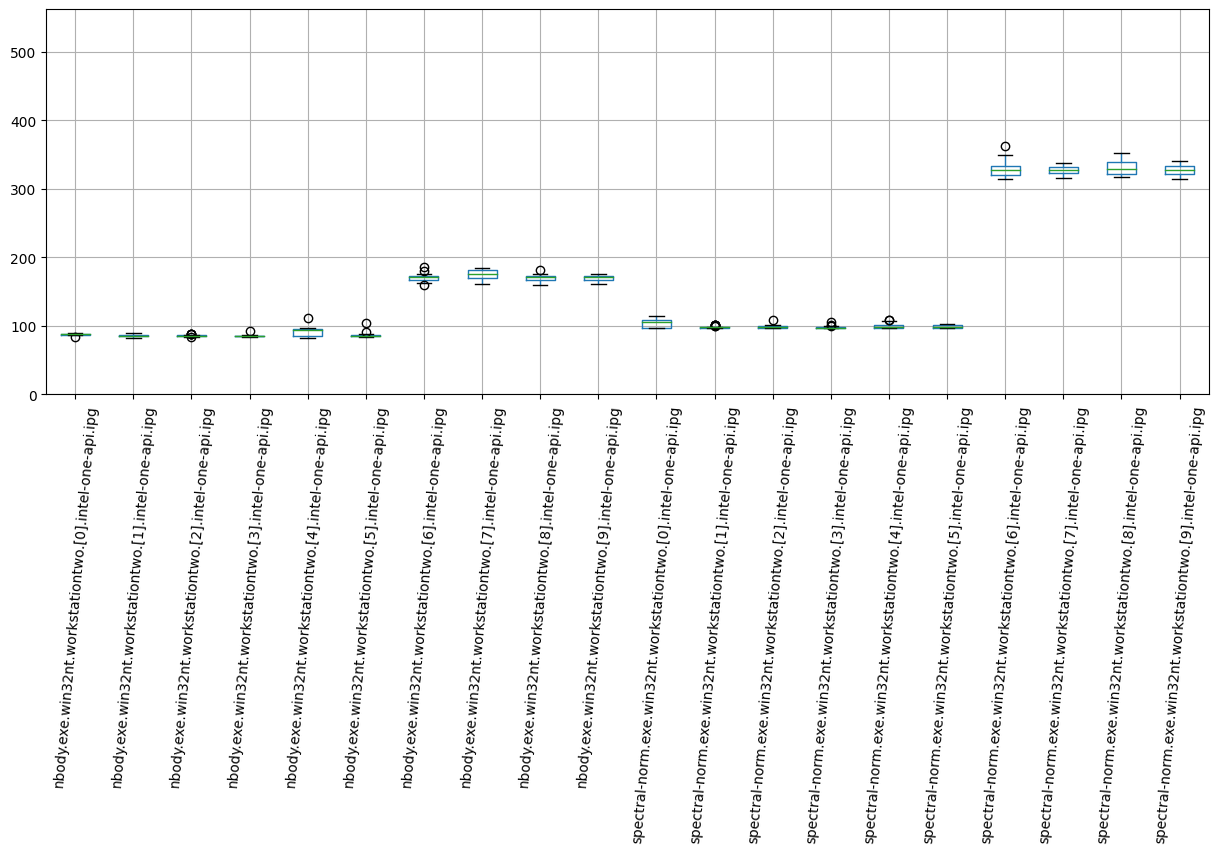

Duration of Test Case


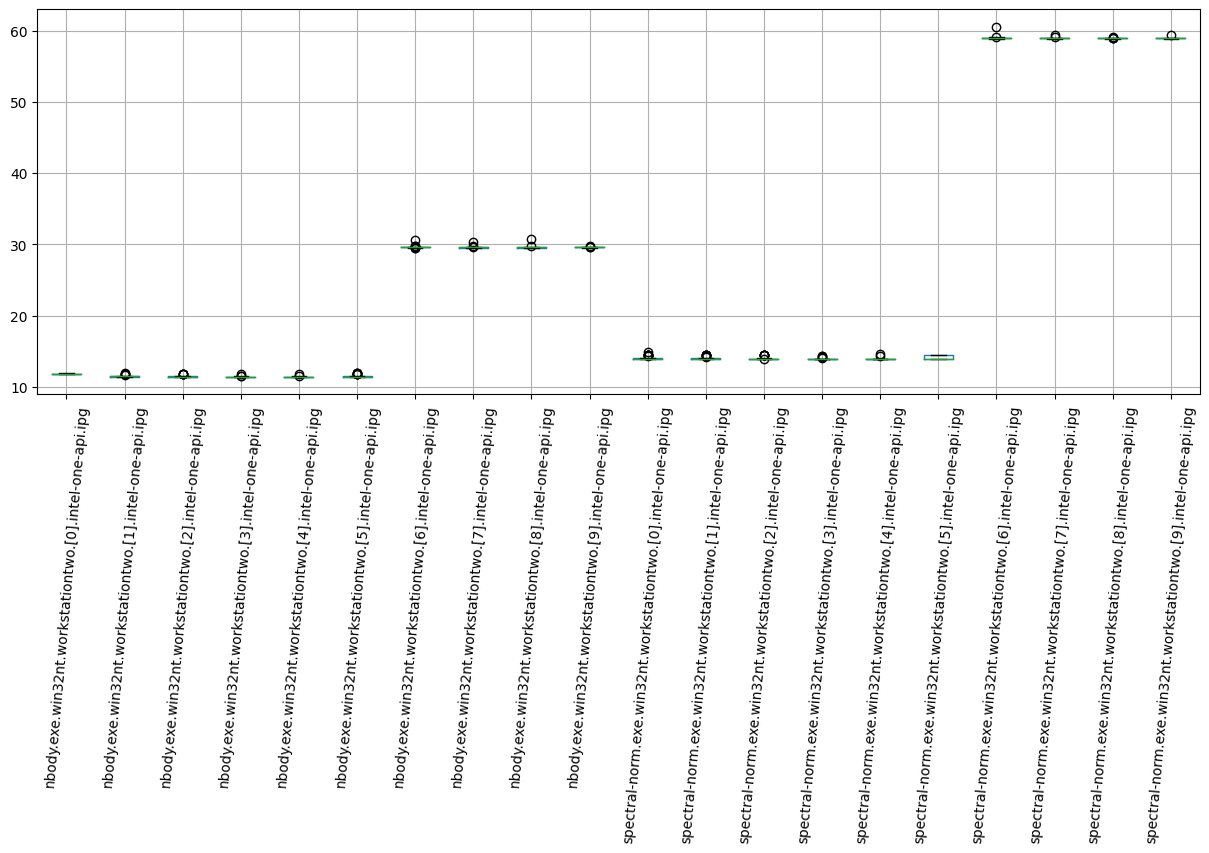

In [82]:
if get_measurements and show_plots:
    test_boxplot = dram_df.boxplot(figsize=(15,1), rot=75, column=[dram_df.columns[0]])
    test_boxplot.plot()
    plot.ylim(0, 40)
    plot.show()
    
    
    # print("Combined DRAM Energy Consumption in Joules")
    # dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=85)
    # # dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=75, column=['fannkuch-redux.exe.ipg.workstationtwo.all.intel-one-api.win32nt'])
    # dram_boxplot.plot()
    # plot.ylim(0, 40)
    # plot.show()

    print("Combined CPU Energy Consumption in Joules")
    cpu_boxplot = cpu_df.boxplot(figsize=(15,5), rot=85)
    cpu_boxplot.plot()
    cpu_boxplot
    plot.ylim(0,max(list(cpu_df.max())) + 200)
    plot.show()

    # print("Combined GPU Energy Consumption in Joules")
    # gpu_boxplot = gpu_df.boxplot(figsize=(15,5), rot=85)
    # gpu_boxplot.plot()
    # plot.ylim(0,50)
    # plot.show()

    print("Duration of Test Case")
    duration_boxplot = duration_df.boxplot(figsize=(15,5), rot=85)
    duration_boxplot.plot()
    # plot.ylim(0,40)
    plot.show()

Dynamic CPU Energy Consumption in Joiles


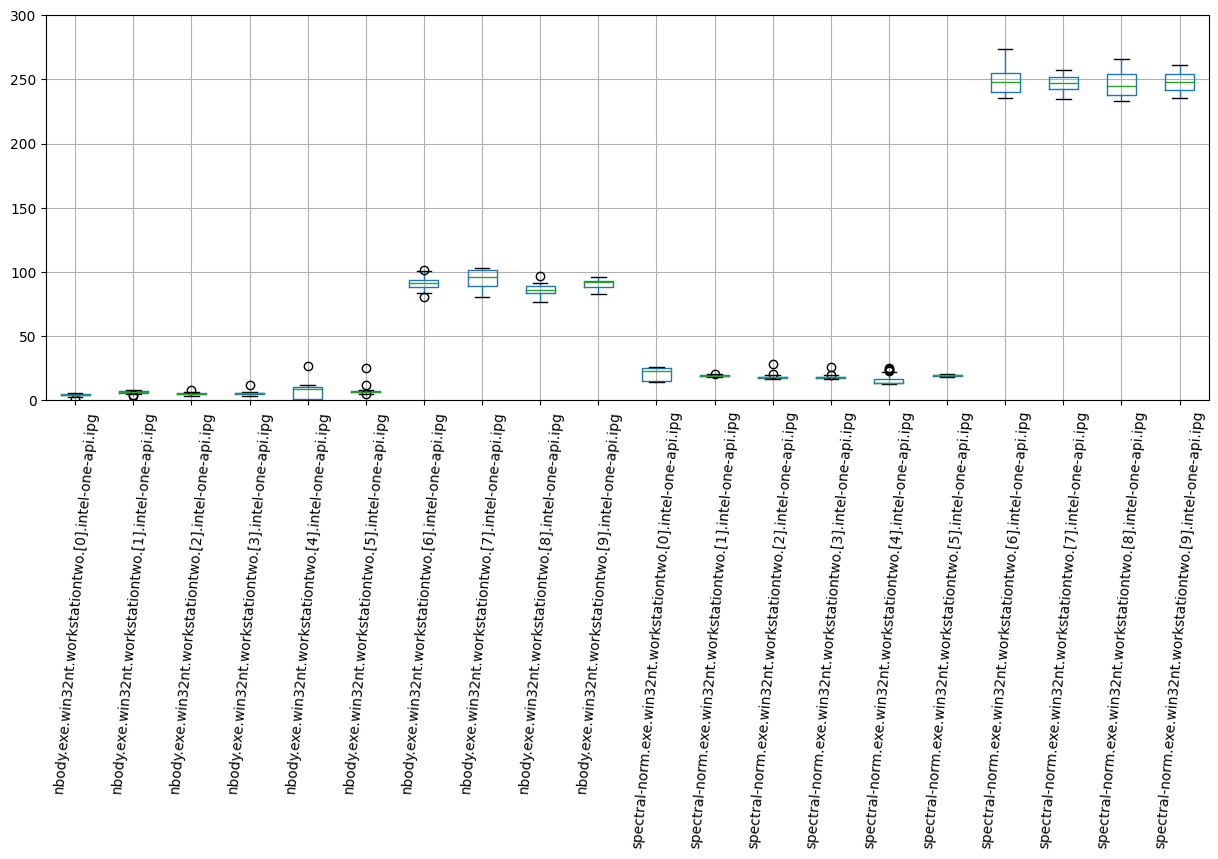

Dynamic CPU Energy Consumption in Watts


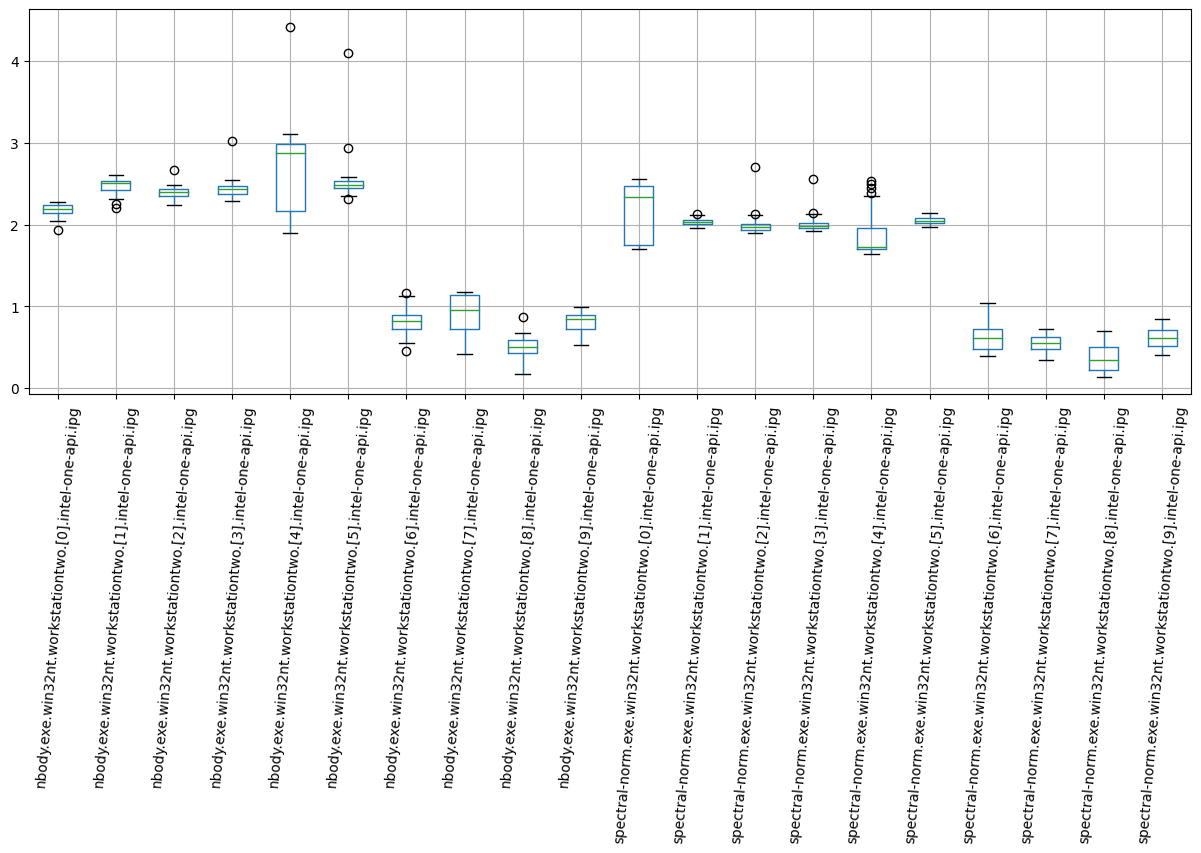

In [83]:
if get_measurements and show_plots:
    # print("Dynamic DRAM Energy Consumption in Watts")
    # dynamic_dram_boxplot = dram_dynamic_df.boxplot(figsize=(15,5), rot=75)
    # dynamic_dram_boxplot.plot()
    # plot.ylim(-0.1, 0.25)
    # plot.show()

    print("Dynamic CPU Energy Consumption in Joiles")
    dynamic_cpu_boxplot = cpu_dynamic_df.boxplot(figsize=(15,5), rot=85)
    dynamic_cpu_boxplot.plot()
    plot.ylim(0,300)
    plot.show()
    
    print("Dynamic CPU Energy Consumption in Watts")
    dynamic_watt_cpu_boxplot = cpu_dynamic_watt_df.boxplot(figsize=(15,5), rot=85)
    dynamic_watt_cpu_boxplot.plot()
    # plot.ylim(0,300)
    plot.show()
    
    

    # print("Dynamic GPU Energy Consumption in Watts")
    # dynamic_gpu_boxplot = gpu_dynamic_df.boxplot(figsize=(15,5), rot=75)
    # dynamic_gpu_boxplot.plot()
    # plot.ylim(-0.1, 0.25)
    # plot.show()


In [84]:
def list_to_label(lst, mapper):
    if len(lst) == 1:
        return mapper[lst[0]]
    elif len(lst) == 2:
        return f"{mapper[lst[0]]} and {mapper[lst[1]]}"
    else:
        return ", ".join([mapper[x] for x in lst[:-1]]) + f" and {mapper[lst[-1]]}"

def get_caption(data_type, name, c_measuring_instrument, c_duts, c_test_cases, c_compiler):
    caption = f"{name} measurements"

    if not ',' in c_measuring_instrument:
        caption += f" by {c_measuring_instrument}"

    if not ',' in c_duts:
        caption += f" on {c_duts}"
        
    if not ',' in c_test_cases:
        caption += f" for test case(s) {c_test_cases}"
        
    if not ',' in c_compiler:
        caption += f" compiled on {c_compiler}"

    return caption

In [85]:
dut_name_mapper = {
    "workstationone" : "DUT 1",
    "workstationtwo" : "DUT 2"
}

compiler_mapper = {
    "clang" : "Clang",
    "min-gw" : "MinGW",
    "intel-one-api" : "oneAPI",
    "msvc" : "MSVC"
}

test_case_mapper = {
    "fannkuch-redux.exe" : "FR",
    "mandelbrot.exe" : "MB",
    "n-body.exe" : "NB",
    "spectra-norm.exe" : "SN"
}

mi_mapper = {
    "ipg" : "IPG",
    "lhm" : "LHM",
    "clamp" : "Clamp",
    "plug" : "Plug",
    "scaphandre" : "SCAP",
    "scaphandre_isolated" : "SCAPI",
    "rapl" : "RAPL"
}

os_mapper = {
    "unix" : 'LIN',
    "win32nt" : "WIN"
}

In [86]:
box_plot_raw_data = [
    {
        "data" : cpu_df,
        "name" : "CPU",
        "data_type" : "energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 2000,
        "xlabel" : "Total Energy Consumption (Joules)"
    },
    {
        "data" : cpu_dynamic_df,
        "name" : "CPU",
        "data_type" : "dynamic energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 1000,
        "xlabel" : "Average Energy Consumption (Joules)"
    },
    {
        "data" : cpu_dynamic_watt_df,
        "name" : "CPU",
        "data_type" : "dynamic energy consumption",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 1000,
        "xlabel" : "Average Energy Consumption (Watts)"
    },
    # {
    #     "data" : dram_dynamic_df,
    #     "name" : "DRAM",
    #     "data_type" : "dynamic energy consumption",
    #     "width" : 0.9,
    #     "xmin" : -0.1,
    #     "xmax" : 0.1,
    #     "xlabel" : "Average Energy Consumption (Watt)"
    # },
    # {
    #     "data" : dram_df,
    #     "name" : "DRAM",
    #     "data_type" : "energy consumption",
    #     "width" : 0.9,
    #     "xmin" : 0,
    #     "xmax" : 40,
    #     "xlabel" : "Total Energy Consumption (Joules)"
    # },
    # {
    #     "data" : gpu_dynamic_df,
    #     "name" : "GPU",
    #     "data_type" : "dynamic energy consumption",
    #     "width" : 0.9,
    #     "xmin" : -0.1,
    #     "xmax" : 0.1,
    #     "xlabel" : "Average Energy Consumption (Watt)"
    # },
    # {
    #     "data" : gpu_df,
    #     "name" : "GPU",
    #     "data_type" : "energy consumption",
    #     "width" : 0.9,
    #     "xmin" : 0,
    #     "xmax" : 50,
    #     "xlabel" : "Total Energy Consumption (Watt)"
    # },
    {
        "data" : duration_df,
        "name" : "Runtime",
        "data_type" : "duration",
        "width" : 0.9,
        "xmin" : 0,
        "xmax" : 50,
        "xlabel" : "Average Runtime (s)"
    }
]

In [87]:
if generate_graphs and get_measurements:
    for plot_data in box_plot_raw_data:
        print("start")
        data = plot_data["data"]
        name = plot_data["name"]
        data_type = plot_data["data_type"]
        width = plot_data["width"]
        height = 0.1 + (len(data.columns) * 0.02)
        xmin = plot_data["xmin"]
        xmax = plot_data["xmax"]
        xlabel = plot_data["xlabel"]
        
        latex_boxes = tex.get_boxes(data)
        plot.clf()
        # latex_boxes = tex.get_boxes(pd.DataFrame(data['fannkuch-redux.exe.ipg.workstationone.all.intel-one-api.win32nt']))
        
        title = f"The {data_type} of the {name}"
        
        ytick = str(list(range(1, len(list(data.columns))+1))).replace('[', '').replace(']', '')
        
        yticklables = tex.get_ytick_labels(
            data, 
            used_test_case_names, 
            used_mi_names, 
            used_dut_name, 
            used_allocated_cores, 
            used_compiler_str, 
            used_os_names,
            dut_name_mapper,
            compiler_mapper,
            test_case_mapper,
            mi_mapper,
            os_mapper
            )
        
        labels = f"{experiment_number}-{experiment_name}-{'-'.join(used_mi_names)}-{'-'.join(used_test_case_names)}-{'-'.join(used_compilers)}-{'-'.join(used_dut_name)}-{name.replace(' ', '_')}-{data_type.replace(' ', '_')}".lower()
        
        c_test_cases = list_to_label(used_test_case_names, test_case_mapper)
        c_compiler = list_to_label(used_compilers, compiler_mapper)
        c_duts = list_to_label(used_dut_name, dut_name_mapper)
        c_measuring_instrument = list_to_label(used_mi_names, mi_mapper)
        
        c_test_cases = c_test_cases.replace(".exe", "")
        
        caption = get_caption(data_type, name, c_measuring_instrument, c_duts, c_test_cases, c_compiler)
        
        latex_box_plot = tex.get_boxplot_template(width, height, xlabel, title, ytick, yticklables, xmin, xmax, latex_boxes, caption, labels)

        box_plot_path = f"{experiment_name}/{'-'.join(used_mi_names)}/{'-'.join(used_test_case_names)}/{'-'.join(used_dut_name)}/{'-'.join(used_compilers)}"
        box_plot_file_name = f"{name}_{data_type.replace(' ', '_')}.tex"
        print(f"generating {box_plot_file_name}")
        # print(data)
        path_util.write_to_path(box_plot_path.replace('.exe', ''), box_plot_file_name, latex_box_plot)
else:
    print("generating plots is disabled")

generating plots is disabled


```latex
\begin{figure}
    \centering
    \begin{tikzpicture}[]
        \pgfplotsset{
            width=WIDTH\textwidth,
            height=WIDHT\textheight
        }
        \begin{axis}[
            xlabel={XLABEL}, 
            title={TITLE}, 
            ytick={YTICK},
        yticklabels={
            LABELS
            },
            xmin=XMIN,xmax=XMAX,
            ]
        
        \addplot+ [boxplot prepared={
        lower whisker=LOW_WHISKER,
        lower quartile=LOW_QUANTILE,
        median=MEDIAN,
        upper quartile=UPPER_QUANTILE,
        upper whisker=UPPER_WHISKER
        }, color = red
        ] coordinates{COORDINATES};
        
        \end{axis}
    \end{tikzpicture}
\caption{CAPTION} \label{fig:LABEL}
\end{figure}
```

In [88]:
# \addplot[mark=none, blue] coordinates {(1000,0) (1000,5)};

In [89]:
cpu_dynamic_watt_df

,nbody.exe.win32nt.workstationtwo.[0].intel-one-api.ipg,nbody.exe.win32nt.workstationtwo.[1].intel-one-api.ipg,nbody.exe.win32nt.workstationtwo.[2].intel-one-api.ipg,nbody.exe.win32nt.workstationtwo.[3].intel-one-api.ipg,nbody.exe.win32nt.workstationtwo.[4].intel-one-api.ipg,nbody.exe.win32nt.workstationtwo.[5].intel-one-api.ipg,nbody.exe.win32nt.workstationtwo.[6].intel-one-api.ipg,nbody.exe.win32nt.workstationtwo.[7].intel-one-api.ipg,nbody.exe.win32nt.workstationtwo.[8].intel-one-api.ipg,nbody.exe.win32nt.workstationtwo.[9].intel-one-api.ipg,spectral-norm.exe.win32nt.workstationtwo.[0].intel-one-api.ipg,spectral-norm.exe.win32nt.workstationtwo.[1].intel-one-api.ipg,spectral-norm.exe.win32nt.workstationtwo.[2].intel-one-api.ipg,spectral-norm.exe.win32nt.workstationtwo.[3].intel-one-api.ipg,spectral-norm.exe.win32nt.workstationtwo.[4].intel-one-api.ipg,spectral-norm.exe.win32nt.workstationtwo.[5].intel-one-api.ipg,spectral-norm.exe.win32nt.workstationtwo.[6].intel-one-api.ipg,spectral-norm.exe.win32nt.workstationtwo.[7].intel-one-api.ipg,spectral-norm.exe.win32nt.workstationtwo.[8].intel-one-api.ipg,spectral-norm.exe.win32nt.workstationtwo.[9].intel-one-api.ipg
0,2.110792,2.530171,2.388060,2.423650,2.086950,2.348226,1.166676,0.635152,0.371581,0.946551,1.742876,1.975663,1.935189,2.558300,1.710602,2.025175,0.783930,0.502814,0.499841,0.612891
1,2.257690,2.503492,2.434069,2.308854,2.886484,2.462606,0.807492,0.947790,0.578227,0.812612,2.347894,2.043483,1.920918,1.954471,2.277959,2.002352,0.600122,0.345686,0.324179,0.405986
2,2.061560,2.200078,2.315224,2.301971,2.731979,2.395745,0.808895,0.956692,0.433324,0.654007,2.281850,2.118529,1.909588,1.944193,1.681420,2.017469,0.483884,0.351788,0.228326,0.515303
3,2.169429,2.416688,2.448573,2.375331,2.887303,2.384781,0.673256,1.092267,0.327526,0.539371,2.326018,1.979228,1.893312,1.938264,2.281602,2.008312,0.739057,0.640995,0.566831,0.609643
4,2.213168,2.540786,2.400310,2.420381,2.926757,2.504035,0.898153,1.075963,0.464675,0.887597,2.415612,2.064855,1.937796,1.992250,1.686470,2.066959,0.716744,0.474792,0.340909,0.773466
5,2.187735,2.523790,2.423488,2.440731,2.939208,2.557146,0.861395,1.146570,0.539653,0.854395,2.443561,2.065681,1.970278,1.987227,2.392469,2.073140,0.865941,0.620788,0.698587,0.843839
6,2.222581,2.526742,2.444467,2.468516,2.946728,2.519302,0.896819,1.127946,0.669772,0.931542,2.559290,2.054683,1.947579,2.072992,2.536026,2.128828,0.902143,0.668910,0.686548,0.673459
7,2.241434,2.472523,2.371916,2.412977,2.981493,2.454786,0.734166,0.938053,0.538038,0.883755,2.470439,2.046519,2.011219,1.988641,2.355235,2.036699,0.570259,0.469567,0.449148,0.616103
8,2.159951,2.521338,2.321110,2.326749,2.875577,2.410962,0.697017,1.064800,0.486236,0.626741,2.346381,2.043965,1.904701,1.945793,1.669509,2.001623,0.445931,0.649269,0.146939,0.412896
9,1.932852,2.253769,2.237835,2.291946,2.028501,2.415074,0.566680,0.421579,0.178775,0.525959,1.708493,1.985949,1.897255,1.934915,2.085434,1.966624,0.441838,0.415976,0.161695,0.566280


In [90]:
cochrans_data = {
    "" : ["with", "without", "count"]
}

if get_measurements:
    Z = 1.96
    E = 0.03

    # Z = 2.58
    # E = 0.01

    include_outliers = False

    used_df = cpu_dynamic_watt_df

    for column in used_df.columns:
        used_df_without_outlisers = math_util.exclude_outliers(used_df, column)
        
        current_count = used_df[column].count()
        
        values = used_df_without_outlisers
        n_zero_without = math_util.get_cochran(values, Z, E)
        
        values = list(used_df[column])
        n_zero = math_util.get_cochran(values, Z, E)
        
        cochrans_data[column] = [round(n_zero, 1), round(n_zero_without, 1), current_count]

pd.DataFrame(cochrans_data).T

,0,1,2
,with,without,count
nbody.exe.win32nt.workstationtwo.[0].intel-one-api.ipg,24.4,16.6,32.0
nbody.exe.win32nt.workstationtwo.[1].intel-one-api.ipg,41.5,25.4,32.0
nbody.exe.win32nt.workstationtwo.[2].intel-one-api.ipg,24.1,15.0,32.0
nbody.exe.win32nt.workstationtwo.[3].intel-one-api.ipg,64.0,17.1,32.0
nbody.exe.win32nt.workstationtwo.[4].intel-one-api.ipg,1220.4,807.2,32.0
nbody.exe.win32nt.workstationtwo.[5].intel-one-api.ipg,379.7,14.8,32.0
nbody.exe.win32nt.workstationtwo.[6].intel-one-api.ipg,92.0,62.5,32.0
nbody.exe.win32nt.workstationtwo.[7].intel-one-api.ipg,240.4,240.4,32.0
nbody.exe.win32nt.workstationtwo.[8].intel-one-api.ipg,84.5,67.6,32.0
